In [9]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod as SamAutomaticMaskGenerator
import numpy as np
import torch
import functions as fnc
import gc
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

In [2]:
OutDIR='/DATA/vito/output/'
DataDIR='/DATA/vito/data/'
MODEL_TYPE = "vit_h"

if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    print('Currently running on GPU\nModel '+MODEL_TYPE)
else:
    DEVICE = torch.device('cpu')
    print('Currently running on CPU\nModel '+MODEL_TYPE)

if MODEL_TYPE == 'vit_h':
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_h_4b8939.pth'
elif MODEL_TYPE == 'vit_l':
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_l_0b3195.pth'
else:
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_b_01ec64.pth'

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

Currently running on GPU
Model vit_h


In [3]:
try:
    test_outputs=np.load('/DATA/vito/output/colour_test_single/collect_test.npy', allow_pickle=True).tolist()
    print('record loaded')
except:
    test_outputs=[]
    print('No record found, created new list')

record loaded


In [4]:
color_pair=np.array(np.meshgrid(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1))).T.reshape(-1,2)

In [ ]:
for run in range(121):
    inner=True#False
    var=True#False

    #create image and noise
    all_col=[]
    all_col_mask=[]
    label=1
    for r in [4,6,8,10]:
        temp_row=[]
        temp_row_mask=[]
        for std in [0,10,25,40]:
            mask=fnc.make_circle(r)
            rgb_sphere=np.zeros((256,256,3))#fnc.circle_colouring(mask)
            if inner:
                if var:
                    std_edge=std/2
                    noisy_image=fnc.add_guassian_noise_to_circle(rgb_sphere,0,std,mask,std_edge)
                else:
                    noisy_image=fnc.add_guassian_noise_to_circle(rgb_sphere,0,std,mask)
            else:
                noisy_image=fnc.add_guassian_noise_to_circle(rgb_sphere,0,std)
            temp_row.append(noisy_image)
            temp_row_mask.append((mask).astype(int)*label)
            label+=1
        all_col.append(np.vstack(temp_row))
        all_col_mask.append(np.vstack(temp_row_mask))
    noise_layer=np.hstack(all_col)
    all_mask=np.hstack(all_col_mask)

    All_nearest_iou=[]
    All_max_iou=[]
    
    for channel in range(3):
        RGB=[128,128,128]
        RGB_edge=[128,128,128]
        RGB[channel]=int(color_pair[run][0]*255)
        RGB_edge[channel]=int(color_pair[run][1]*255)
        image=fnc.circle_colouring_specified(all_mask!=0, RGB, RGB_edge)
        image=image+noise_layer

        #calculate color contrast
        RGB_nor=fnc.normalize_rgb(RGB)
        RGB_edge_nor=fnc.normalize_rgb(RGB_edge)

        ad=fnc.angular_distance(RGB_nor,RGB_edge_nor)
        ed=fnc.euclidean_distance(RGB,RGB_edge)

        #apply guassian filter
        #xl=[1,3,5,7,9,11,13,15,17,19,21]
        #for k in xl:
        temp_image=fnc.preprocessing_roulette(image, 
                                            {#'Crop': {'crop size': 1024, 'j':0},
                                                #'Gaussian': {'kernel size':k},
                                                #'CLAHE':{'clip limit':3}#,
                                                # #'Downsample': {'fxy':4}
                                                })
        gc.collect()
        torch.cuda.empty_cache()

        mask_generator = SamAutomaticMaskGenerator(
            model=sam,
            points_per_side=12,
            pred_iou_thresh=0,
            stability_score_thresh=0,#iou by varying cutoff in binary conversion
            box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
            crop_n_layers=0,#cut into 2**n crops
            crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
            crop_n_points_downscale_factor=1,
            crop_overlap_ratio=0,
            #min_mask_region_area=2000,
        )
        with torch.no_grad():
            masks = mask_generator.generate(temp_image)
        #logit_scale=1000

        #prep selection
        seg_labels=(np.unique(all_mask)[1:])

        seg_size=[]
        for seg in seg_labels:
            seg_size.append(np.sum(all_mask==seg))

        seg_size_sort_idx=np.argsort(seg_size)

        list_of_label=[(all_mask==seg_labels[index]).astype(np.uint8) for index in seg_size_sort_idx]
        ar_label=np.stack(list_of_label)

        list_of_masks = [fnc.clean_mask(mask['segmentation'].astype(np.uint8)) for mask in masks]#remove small disconnected parts
        ar_masks=np.stack(list_of_masks)

        ar_all=np.stack(list_of_label+list_of_masks)
        list_of_centroid = [fnc.get_centroid(ar_all[i]) for i in range(len(ar_all))]
        ar_all.shape

        ar_all_flat=ar_all.reshape((ar_all.shape[0],ar_all.shape[1]*ar_all.shape[2]))
        set_overlap = set()

        # Iterate through each column of the array
        for i in range(ar_all_flat.shape[1]):
            # for each pixel find out the idex of mask where the pixel was in a mask
            nz = np.where(ar_all_flat[:, i] != 0)[0]
            
            # if there are overlap of mask
            if len(nz) > 1:
                nz_tuple = tuple(nz)
                set_overlap.add(nz_tuple)

        list_overlap = list(set_overlap)

        #centroid based selection
        tree = KDTree(list_of_centroid)              
        k=10
        _, ind = tree.query(list_of_centroid[:len(list_of_label)], k=k)

        # get nearest centroid iou
        kdc_iou=[]
        nearest_mask_pick=[]
        for match in ind:
            #check if nearest neighbor is not a label
            j=1
            while match[j]<len(list_of_label):
                j+=1
            if j<k:
                kdc_iou.append(fnc.iou(ar_all[match[0]],ar_all[match[j]]))
                nearest_mask_pick.append(match[j])
            else:
                kdc_iou.append(-0.1)

            
        # get all average and max iou
        overlap_by_label=[]
        max_iou=[]
        max_mask_pick=[]
        for i in range(len(list_of_label)):
            all_pairs=[tup for tup in list_overlap if i in tup]
            if len(all_pairs)>0:
                overlap_with_i=np.unique(np.hstack(all_pairs))[1:]
                overlap_by_label.append(overlap_with_i)
                agg_iou=[]
                for j in overlap_with_i:
                    agg_iou.append(fnc.iou(ar_label[i],ar_masks[j-len(list_of_label)]))
                max_iou.append(np.max(agg_iou))
                max_mask_pick.append(overlap_with_i[np.argmax(agg_iou)])
            else:
                overlap_by_label.append(np.array([]))
                max_iou.append(-0.1)
        All_nearest_iou.append(kdc_iou)
        All_max_iou.append(max_iou)
    All_nearest_iou=np.array(All_nearest_iou)
    All_max_iou=np.array(All_max_iou)
    output={'RGB':color_pair[run][0], 'RGB_edge':color_pair[run][1], 
            'angular_distance': ad, 'euclidean_distance':ed, 
            'All_max_iou': All_max_iou, 'All_nearest_iou':All_nearest_iou}
    test_outputs.append(output)
    np.save(f'/DATA/vito/output/colour_test_single/test{run}.npy',output)
    np.save(f'/DATA/vito/output/colour_test_single/collect_test.npy',test_outputs)

In [6]:
max_iou=[out['All_max_iou'] for out in test_outputs]
nearest_iou=[out['All_nearest_iou'] for out in test_outputs]
angular=np.array([out['angular_distance'] for out in test_outputs])
euclidean=np.array([out['euclidean_distance'] for out in test_outputs])

In [13]:
max_iou[0][0]

array([1.90083831e-04, 7.69230769e-01, 7.66666667e-01, 1.96905767e-04,
       4.38356590e-04, 4.70085470e-01, 7.85714286e-01, 8.33333333e-01,
       7.64214585e-04, 7.55000000e-01, 7.55656109e-01, 7.41935484e-01,
       1.22972601e-03, 7.19242902e-01, 8.56287425e-01, 8.69047619e-01])

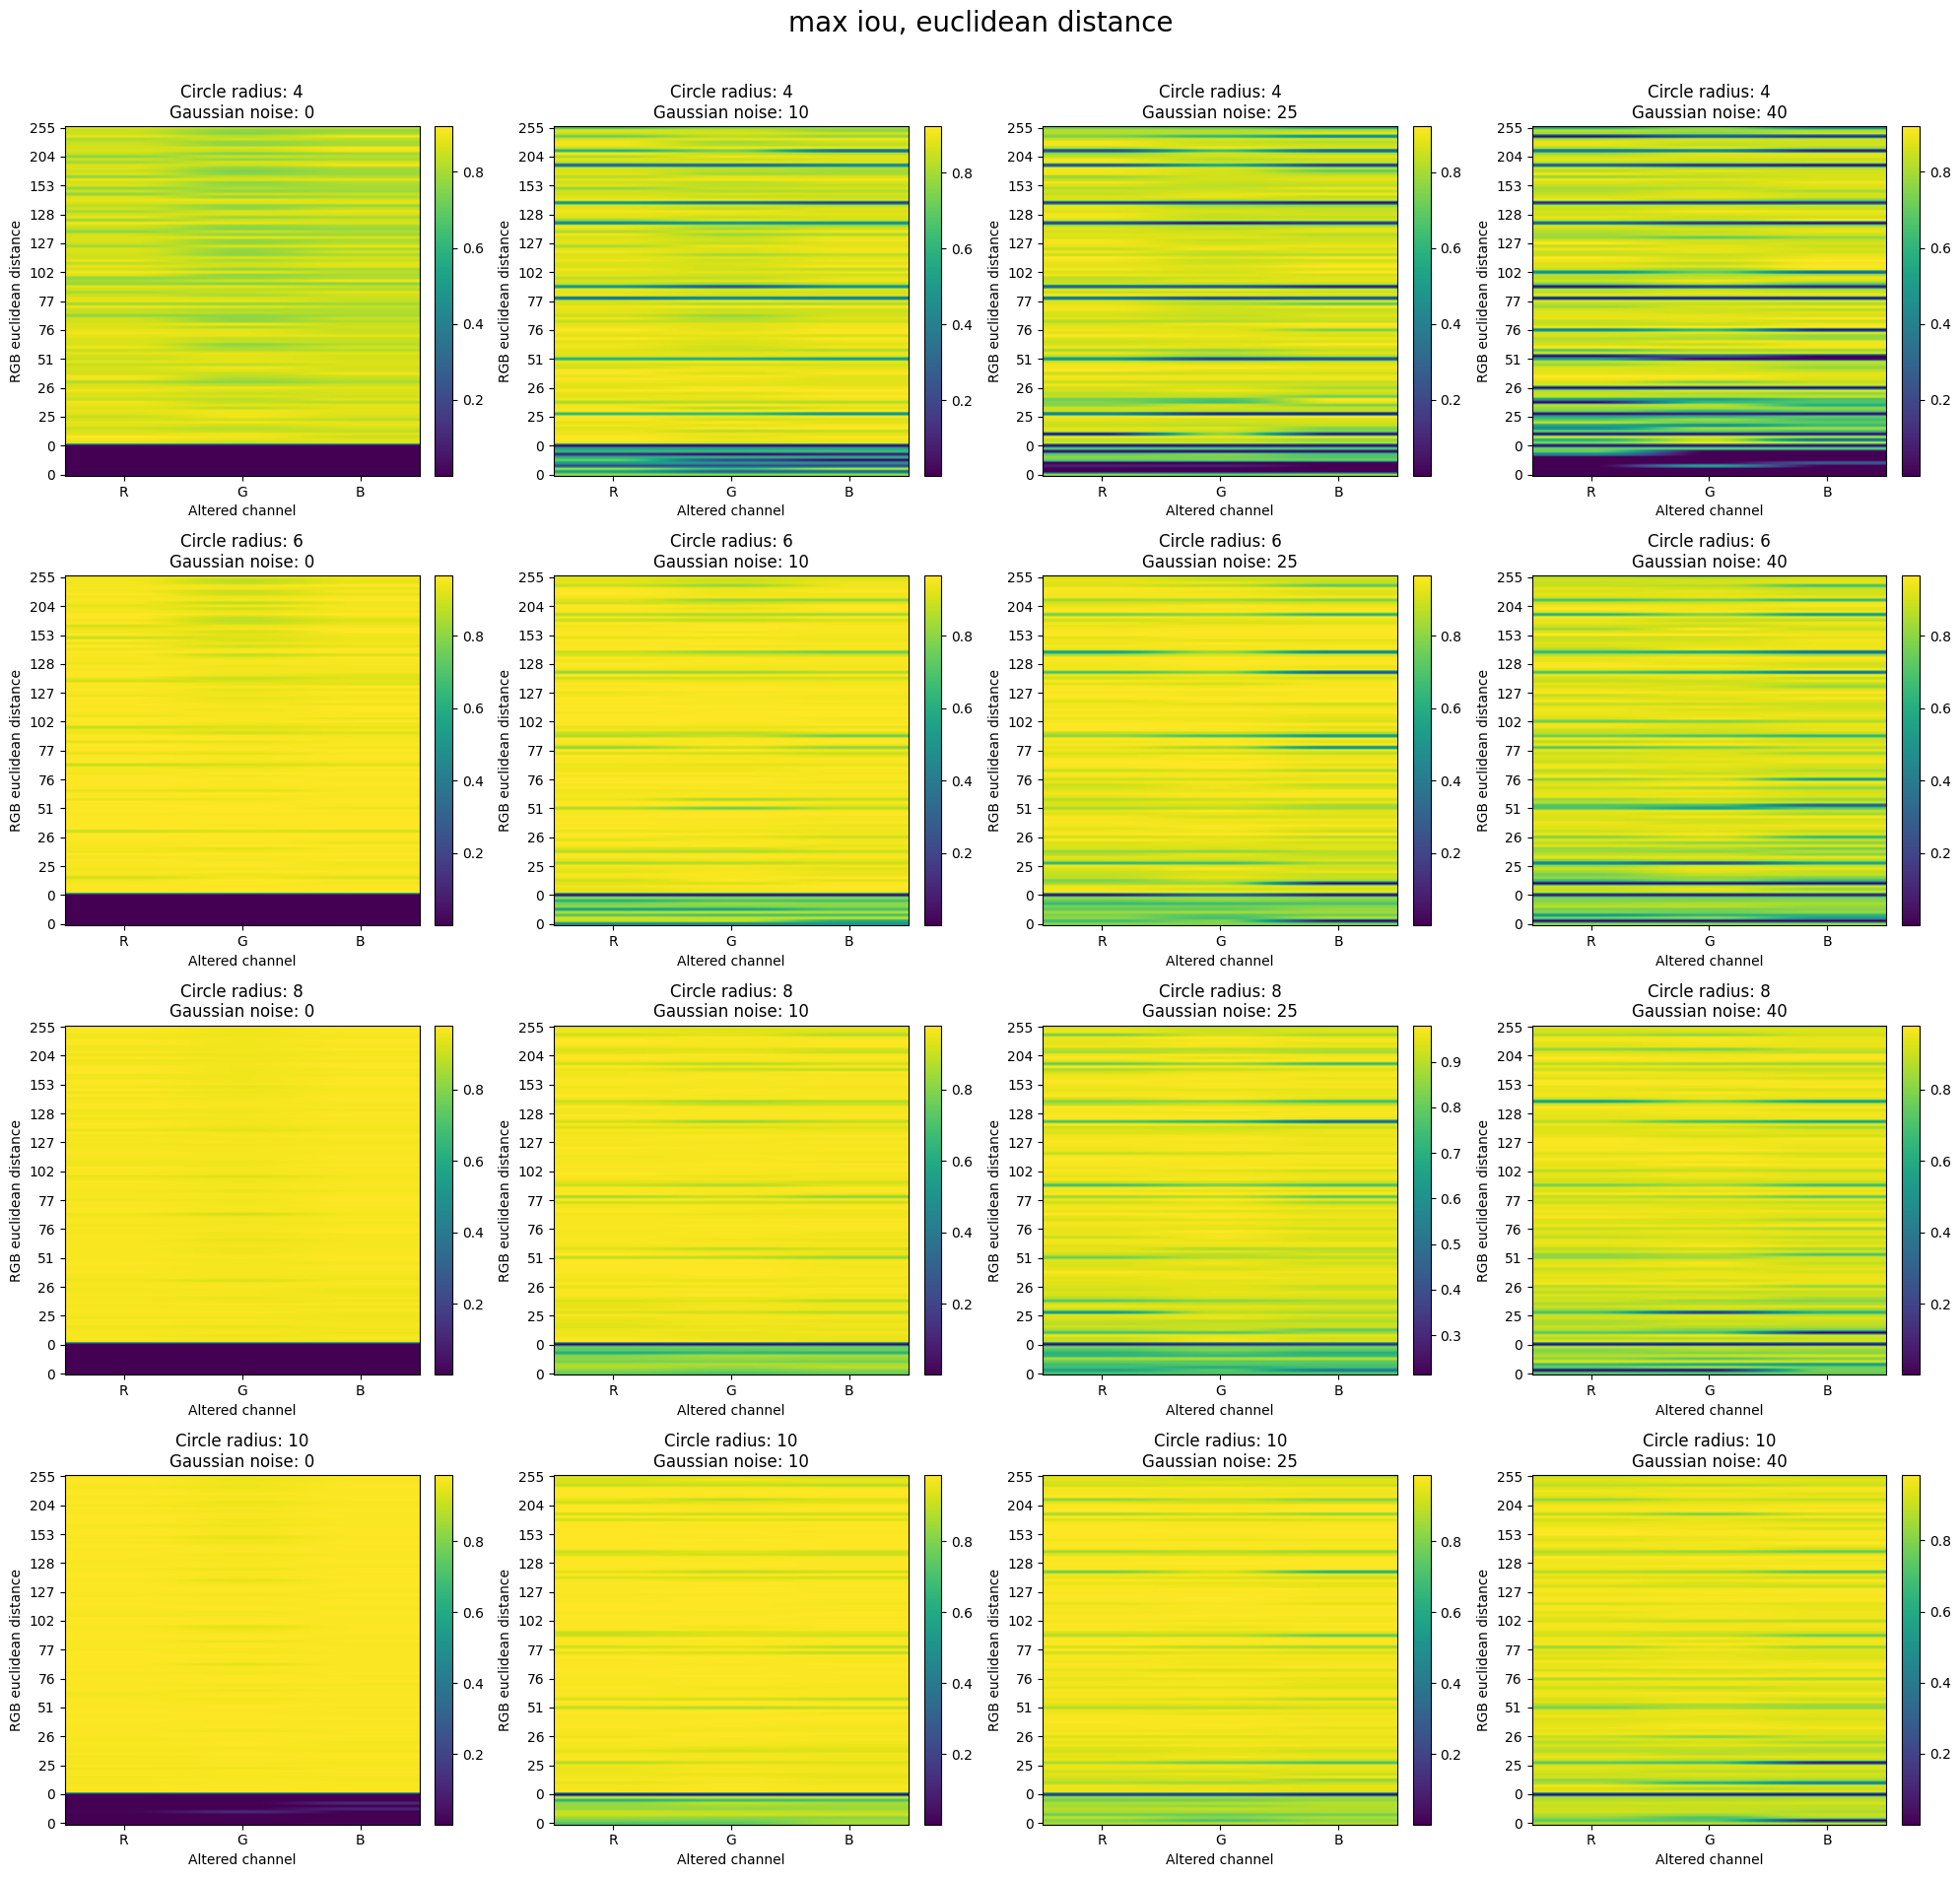

In [16]:
gn=[0,10,25,40]
radi=[4,6,8,10]
euclidean_sorted_id=np.argsort(euclidean)
yticks=np.arange(len(euclidean))
ylabels=np.round(np.sort(euclidean)).astype(int)
xticks=range(len(max_iou[0][:,1]))

plt.figure(figsize=(20, 20))
for i in range(4):#loop through radi
    #plt.figure(figsize=(15, 30))
    for j in range(4):#loop through noise level
        col=i*4+j
        #plt.subplot(1, 4, j+1)
        plt.subplot(4, 4, i*4+j+1)
        plt.title(f'Circle radius: {radi[i]}\nGaussian noise: {gn[j]}')
        plt.imshow(np.vstack([max_iou[arg][:,col] for arg in euclidean_sorted_id]), origin='lower', aspect='auto')
                    #, vmax=1,vmin=0.3, aspect='auto')
        plt.yticks(yticks[::10], ylabels[::10])
        plt.ylabel('RGB euclidean distance')
        plt.xticks(xticks, ['R','G','B'])
        plt.xlabel('Altered channel')
        plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('max iou, euclidean distance', fontsize=20)
plt.show()

/tmp/ipykernel_18305/3096042300.py:5: RuntimeWarning: invalid value encountered in cast
  ylabels=np.round(np.sort(angular)).astype(int)


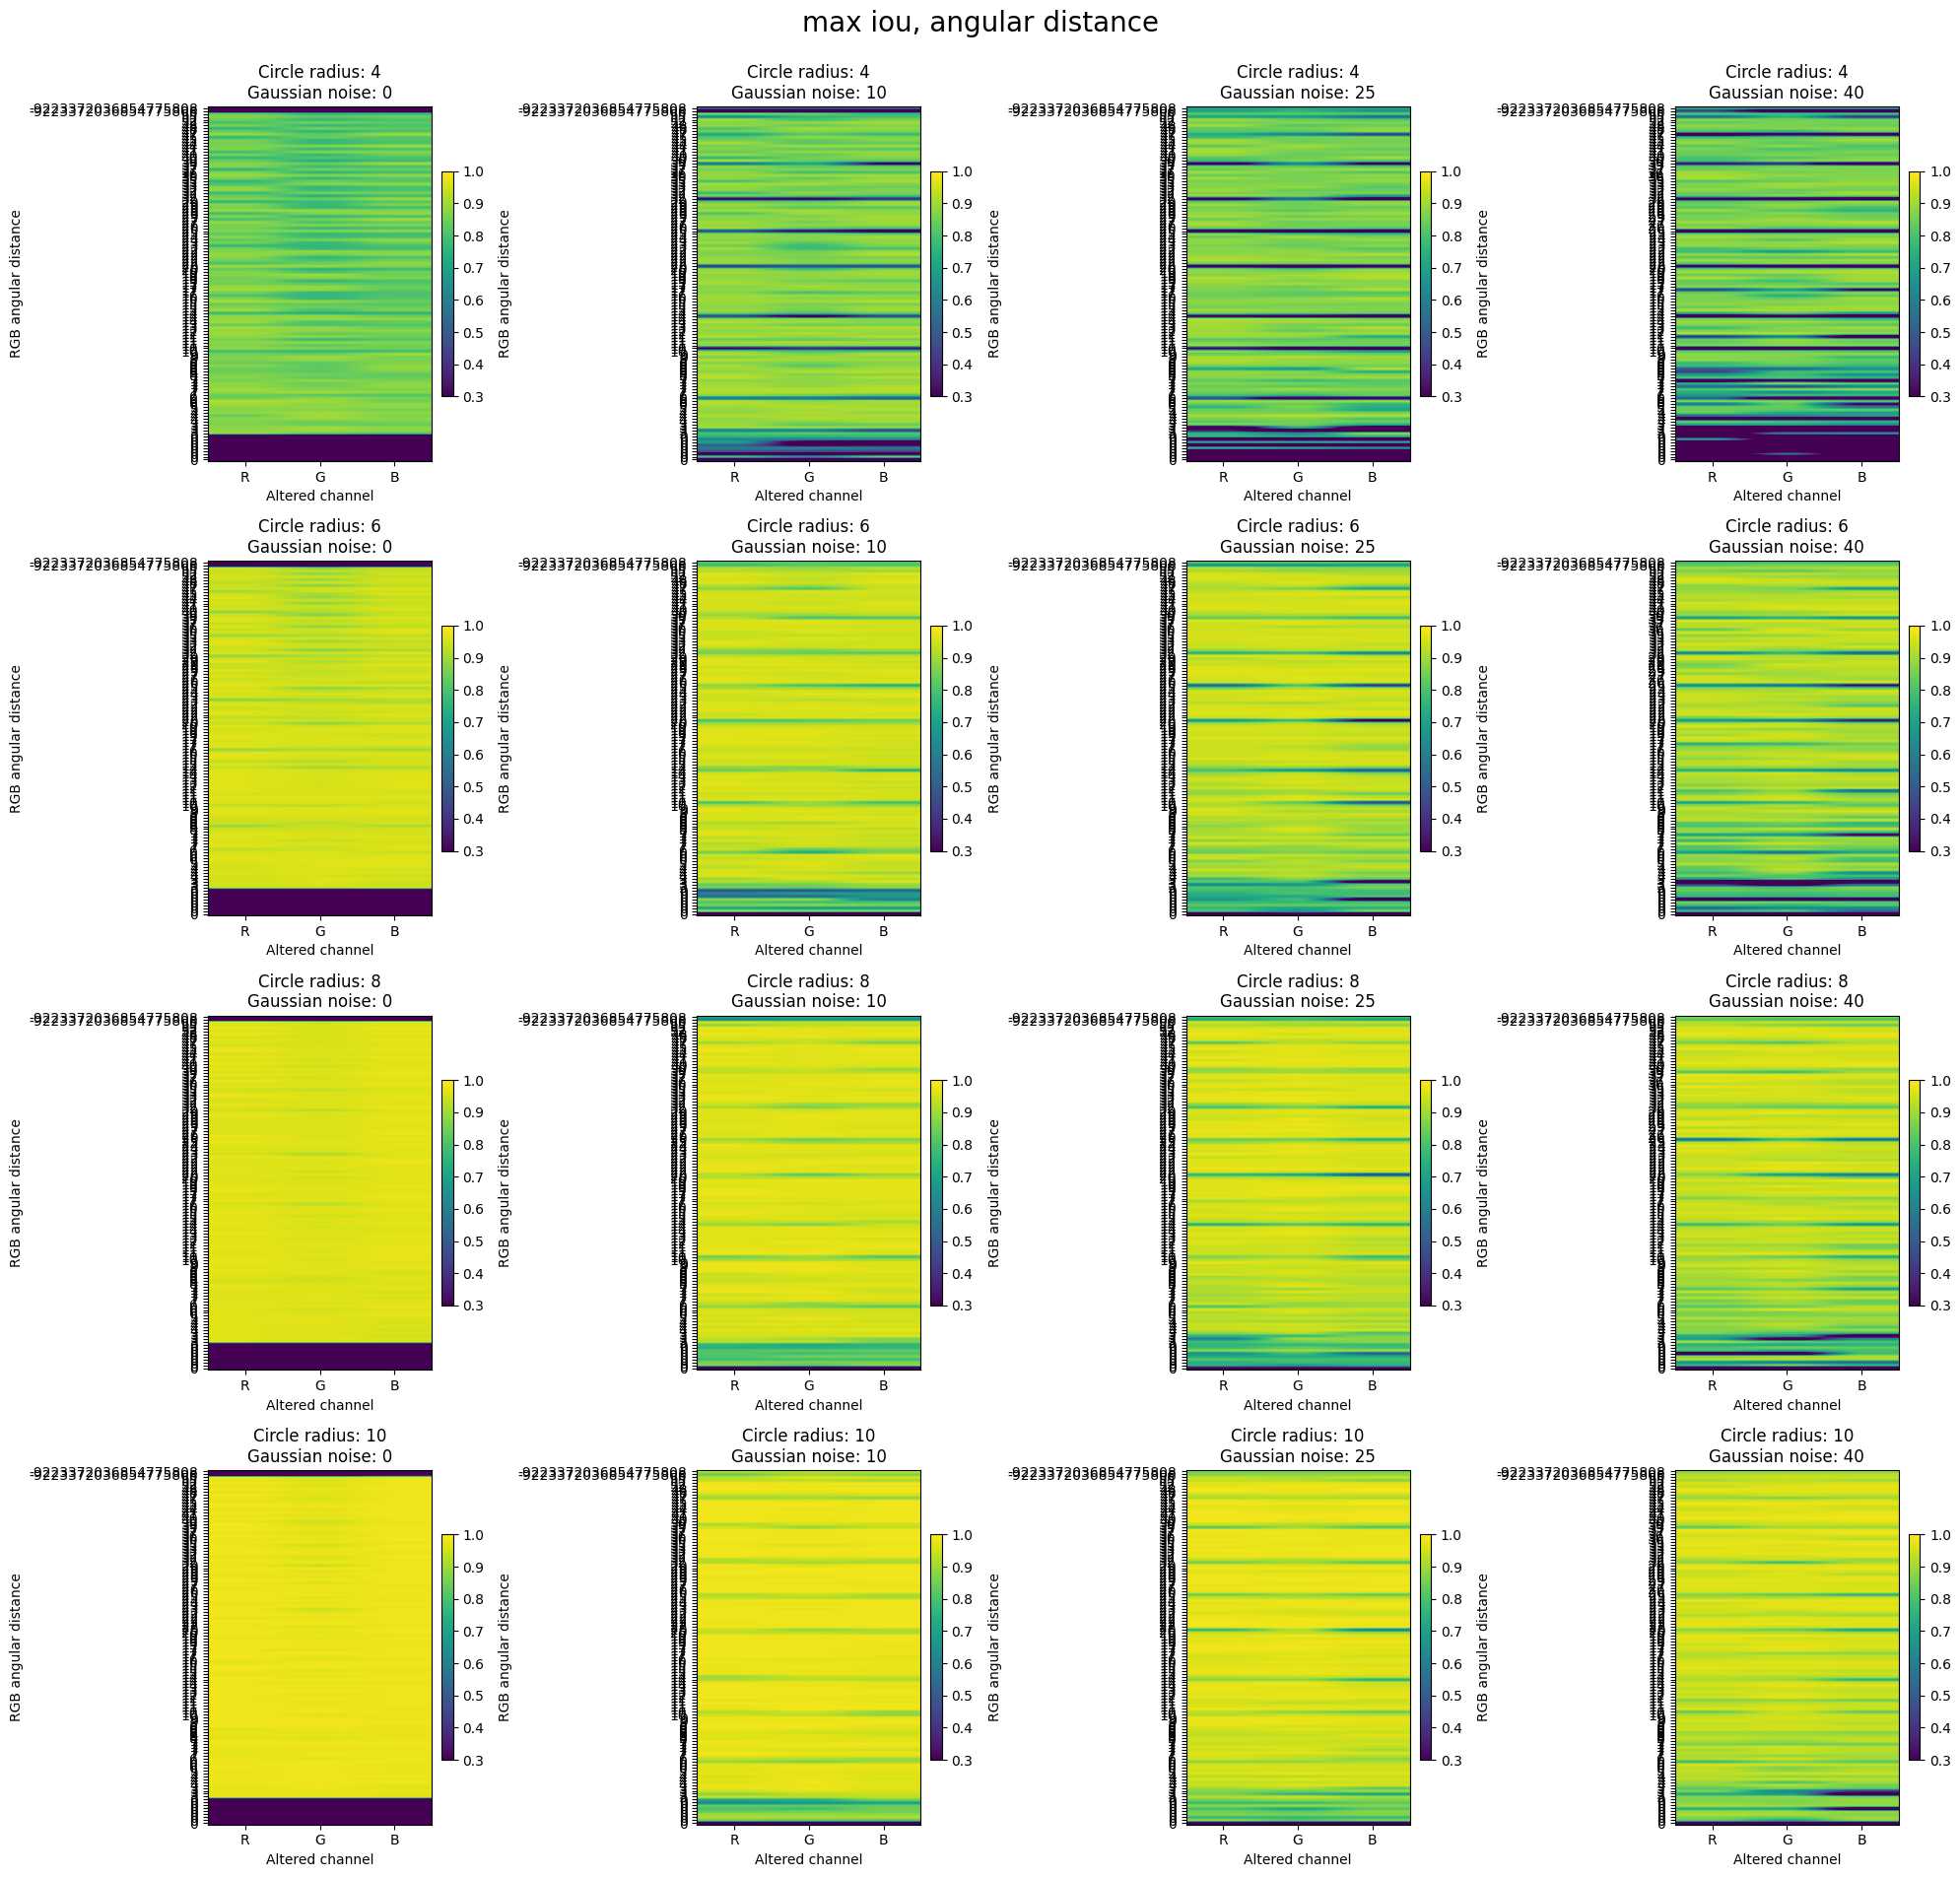

In [19]:
gn=[0,10,25,40]
radi=[4,6,8,10]
angular_sorted_id=np.argsort(angular)
yticks=np.arange(len(angular))
ylabels=np.round(np.sort(angular)).astype(int)
xticks=range(len(max_iou[0][:,1]))

plt.figure(figsize=(20, 20))
for i in range(4):#loop through radi
    
    for j in range(4):#loop through noise level
        col=i*4+j
        plt.subplot(4, 4, i*4+j+1)
        plt.title(f'Circle radius: {radi[i]}\nGaussian noise: {gn[j]}')
        plt.imshow(np.vstack([max_iou[arg][:,col] for arg in angular_sorted_id]), origin='lower', 
                   vmax=1,vmin=0.3, aspect='auto')
        plt.yticks(yticks, ylabels)
        plt.ylabel('RGB angular distance')
        plt.xticks(xticks,  ['R','G','B'])
        plt.xlabel('Altered channel')
        plt.colorbar(fraction=0.046, pad=0.04)


plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.suptitle('max iou, angular distance', fontsize=20)
plt.show()

In [21]:
color_pair[1]

array([0. , 0.1])

In [22]:
np.array(range(121)).reshape((11,11))

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10],
       [ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21],
       [ 22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32],
       [ 33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43],
       [ 44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54],
       [ 55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65],
       [ 66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76],
       [ 77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87],
       [ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98],
       [ 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
       [110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]])

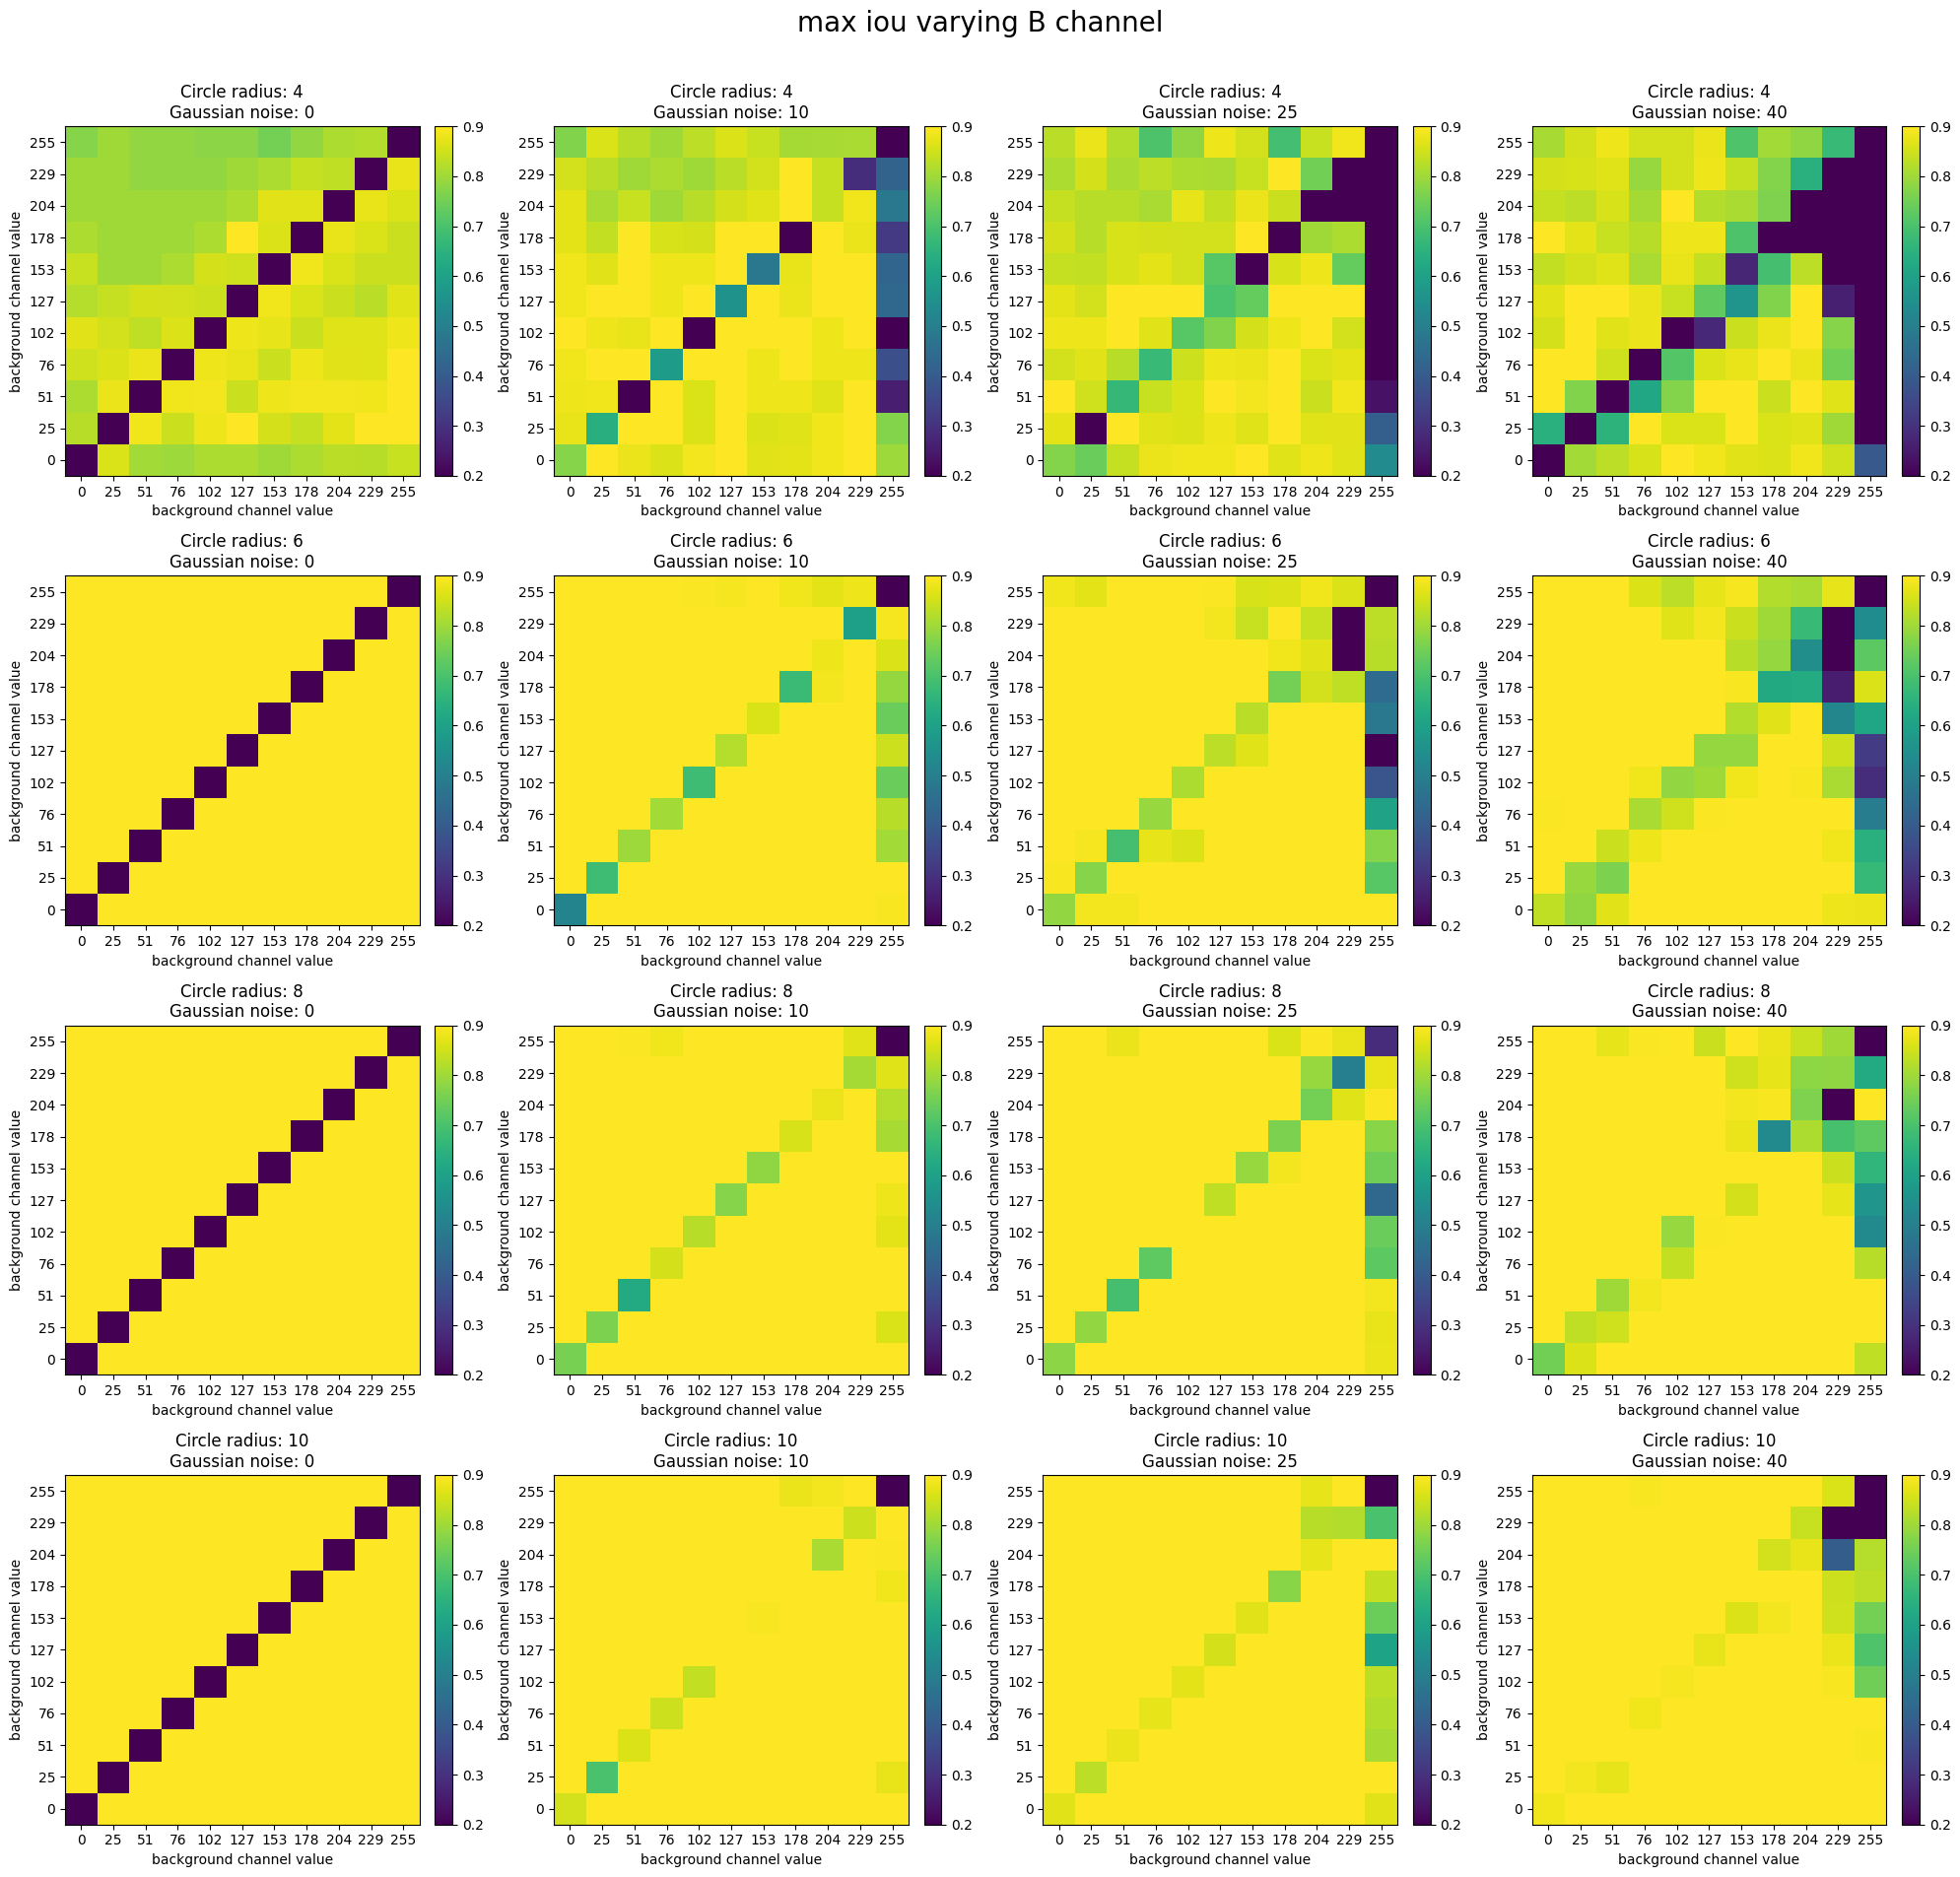

In [34]:
channel=2
channel_s=['R','G','B']
gn=[0,10,25,40]
radi=[4,6,8,10]
yticks=range(11)
ylabels=(np.arange(0,1.1,0.1)*255).astype(int)
xticks=range(11)
xlabels=(np.arange(0,1.1,0.1)*255).astype(int)

plt.figure(figsize=(20, 20))
for i in range(4):#loop through radi
    #plt.figure(figsize=(15, 30))
    for j in range(4):#loop through noise level
        col=i*4+j
        #plt.subplot(1, 4, j+1)
        plt.subplot(4, 4, i*4+j+1)
        plt.title(f'Circle radius: {radi[i]}\nGaussian noise: {gn[j]}')
        plt.imshow(np.vstack([arg[:,col][channel] for arg in max_iou]).reshape((11,11)), origin='lower'#, aspect='auto')
                    , vmax=0.9,vmin=0.2, aspect='auto')
        plt.yticks(yticks, ylabels)
        plt.ylabel('background channel value')
        #plt.xticks(xticks, ['R','G','B'])
        plt.xticks(xticks, xlabels)
        plt.xlabel('background channel value')
        plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f'max iou varying {channel_s[channel]} channel', fontsize=20)
plt.show()